# 使用遷移學習Transfer Learning Sentiment analysis

# KerasFastText-使用fasttext之自己supervised預訓練模型-(train20%)

In [1]:
import copy
import numpy as np
import pandas as pd
# import matplotlib.pyplot as plt
import sys
import os
import re

# from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling1D
from keras.optimizers import SGD, RMSprop
from keras.utils import np_utils
from keras.layers.convolutional import Convolution1D, MaxPooling1D, ZeroPadding1D, AveragePooling1D
from keras.callbacks import EarlyStopping
from keras.layers.normalization import BatchNormalization
from keras.preprocessing import sequence
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import SimpleRNN, LSTM, GRU
from keras.layers.wrappers import TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import Callback
from keras.optimizers import *

Using TensorFlow backend.


# Hotel data格式前處理

透過clean_dataset整理資料

label必須編碼為0,1,2,3,..

In [2]:
import pandas as pd

In [3]:
data=pd.read_csv('./data/hotel_data.csv',encoding='utf8')
data = data[['text','polarity']]

In [4]:
data.head(10)

,text,polarity
0,My daughter and I just returned from a four ni...,NEGATIVE
1,I had searched for a good hotel at a rate of u...,OBJECTIVE
2,Big mistake.,NEGATIVE
3,"Our room was tiny,",NEGATIVE
4,and the bath was small too.,NEGATIVE
5,The public areas were somewhat dingy and showe...,NEGATIVE
6,Even the bath towels were worn and becoming st...,NEGATIVE
7,"Speaking of such, the maid did not replace sha...",NEGATIVE
8,You had to put a sign on the bed if you wanted...,NEGATIVE
9,The minibar was one of the kind that you have ...,NEGATIVE


In [5]:
print(data[ data['polarity'] == 'POSITIVE'].size)
print(data[ data['polarity'] == 'NEGATIVE'].size)
print(data[ data['polarity'] == 'OBJECTIVE'].size)

23046
25020
15200


In [6]:
data = data[ (data['polarity'] == 'POSITIVE') |(data['polarity'] == 'NEGATIVE')]

In [7]:
print(data[ data['polarity'] == 'POSITIVE'].size)
print(data[ data['polarity'] == 'NEGATIVE'].size)
print(data[ data['polarity'] == 'OBJECTIVE'].size)

23046
25020
0


In [8]:
data['polarity'] = data['polarity'].replace({'POSITIVE': 1, 'NEGATIVE': 0})

In [9]:
data = data.rename(columns={'polarity':'label'})

In [10]:
data.head(3)

,text,label
0,My daughter and I just returned from a four ni...,0
2,Big mistake.,0
3,"Our room was tiny,",0


In [11]:
## 切資料

from sklearn.model_selection import train_test_split

X_train_, X_test_, Y_train, Y_test = \
    train_test_split( data['text'], data['label'], test_size=0.8, random_state=42, stratify = data['label'])

/opt/conda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/conda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [12]:
input_text = data['text']

In [13]:
input_text[0:2]

0    My daughter and I just returned from a four ni...
2                                         Big mistake.
Name: text, dtype: object

In [14]:
input_text.shape

(24033,)

In [15]:
# 20000
num_words = 20000
tok = Tokenizer(num_words)
tok.fit_on_texts(input_text)

In [16]:
len(tok.word_index)

13117

In [17]:
X_train = tok.texts_to_sequences(X_train_)
X_test  = tok.texts_to_sequences(X_test_)

X_train = sequence.pad_sequences(X_train, maxlen=200)
X_test  = sequence.pad_sequences(X_test,  maxlen=200)

In [18]:
X_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [19]:
len(X_train)

4806

In [20]:
Y_train[0:10]

19053    0
594      0
24210    0
13343    1
13903    0
6290     0
7862     1
13824    0
24539    1
23987    1
Name: label, dtype: int64

In [21]:
len(Y_train)

4806

In [22]:
Y_train

19053    0
594      0
24210    0
13343    1
13903    0
6290     0
7862     1
13824    0
24539    1
23987    1
31471    0
1616     0
30509    1
25472    0
18666    0
14192    1
127      1
13238    0
3271     0
18494    1
14377    1
11257    1
26447    0
19267    1
14270    0
21465    0
9967     0
21562    0
18038    1
12932    0
        ..
3072     1
18117    0
1021     0
9244     1
12472    0
24381    0
2318     0
4431     0
28721    1
7301     0
9506     0
5231     0
25559    0
20787    0
21080    1
24214    1
17020    1
10073    0
23684    0
4125     0
19144    1
28339    1
26003    1
234      0
8255     1
16080    0
6030     0
18127    0
19235    0
27176    1
Name: label, dtype: int64

# 預先訓練好的詞向量在這裡讀

In [23]:
from pyfasttext import FastText

In [24]:
fasttext_model = FastText('./model/skip_model_13.bin')

In [25]:
words = []
for iter in range(num_words):
    words += [key for key,value in tok.word_index.items() if value==iter+1]

In [26]:
words[:10]

len(words)

13117

In [27]:
weights = np.zeros((num_words,10))
count=0
for idx, w in enumerate(words):
    try:
        weights[idx,:] = fasttext_model.get_numpy_vector(w)
    except KeyError as e:
        #pass
        count=count+1

In [28]:
count

0

In [29]:
weights.shape

(20000, 10)

In [30]:
weights[0]

array([ 0.51421237,  0.33238244, -0.22854866, -0.07036001,  0.01268008,
        0.08718   , -0.50573528, -0.16250093,  0.55880743,  0.27797019])

In [31]:
weights.shape

(20000, 10)

# 自己繪圖展示train, validation, test準確率

In [32]:
%matplotlib inline
from keras.callbacks import Callback
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
    def on_epoch_end(self,epoch, logs={}):
        x, y = X_test, Y_test
        lss, acc = self.model.evaluate(x, y, verbose=0)
        #self.losses.append([logs.get('loss'),logs.get('acc'),logs.get('val_loss'),logs.get('val_acc'),lss, acc])
        self.losses.append({'train_loss':logs.get('loss'),'train_metrics':logs.get('acc'),
                            'val_loss':logs.get('val_loss'),'val_metrics':logs.get('val_acc'),
                            'test_loss':lss,'test_metrics':acc,
                           })
        #trlss = logs.get('loss')
        #tracc = logs.get('acc')
        #valss = logs.get('val_loss')
        #vaacc = logs.get('val_acc')
        #print('\nepochs:{}'.format(epoch))
        #print('\nTrain loss: {}, acc: {}'.format(trlss, tracc))
        #print('\nValidation loss: {}, acc: {}'.format(valss, vaacc)) 
        #print('\nTesting loss: {}, acc: {}'.format(lss, acc))

# LSTM

In [33]:
model = Sequential()
model.add(Embedding(num_words, 10, input_length= 200))
model.add(Dropout(0.5))

model.add(LSTM(16,activation='relu'))

model.add(Dense(128))
model.add(Dropout(0.5))
model.add(Activation('relu'))

#model.add(GlobalAveragePooling1D())
#model.add(Dense(1, activation='softmax'))

model.add(Dense(1))
model.add(Activation('sigmoid'))

#詞嵌入 採用預訓練的 向量
model.layers[0].set_weights([weights])
model.layers[0].trainable = True

#optim = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(loss='binary_crossentropy', optimizer = 'Adam' , metrics=['accuracy'])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 10)           200000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200, 10)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                1728      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               2176      
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
__________

In [34]:
%%time
history = LossHistory()
hist=model.fit(X_train, Y_train, batch_size= 32, epochs=10, validation_split=0.1, callbacks=[history])

Train on 4325 samples, validate on 481 samples
Epoch 1/10
4325/4325 [==============================] - 32s 7ms/step - loss: 0.6902 - acc: 0.5378 - val_loss: 0.6868 - val_acc: 0.5676
Epoch 2/10
4325/4325 [==============================] - 26s 6ms/step - loss: 0.6793 - acc: 0.5704 - val_loss: 0.6675 - val_acc: 0.5967
Epoch 3/10
4325/4325 [==============================] - 25s 6ms/step - loss: 0.6533 - acc: 0.6234 - val_loss: 0.6423 - val_acc: 0.6632
Epoch 4/10
4325/4325 [==============================] - 26s 6ms/step - loss: 0.6153 - acc: 0.6664 - val_loss: 0.5978 - val_acc: 0.6757
Epoch 5/10
4325/4325 [==============================] - 26s 6ms/step - loss: 0.5829 - acc: 0.6957 - val_loss: 0.5768 - val_acc: 0.6965
Epoch 6/10
4325/4325 [==============================] - 27s 6ms/step - loss: 0.5578 - acc: 0.7172 - val_loss: 0.5614 - val_acc: 0.7235
Epoch 7/10
4325/4325 [==============================] - 26s 6ms/step - loss: 0.5347 - acc: 0.7385 - val_loss: 0.5446 - val_acc: 0.7297
Epoch 8/

In [35]:
hist_info = pd.DataFrame(history.losses)

In [36]:
hist_info

,test_loss,test_metrics,train_loss,train_metrics,val_loss,val_metrics
0,0.685894,0.555469,0.690246,0.537803,0.686850,0.567568
1,0.666706,0.615489,0.679275,0.570405,0.667516,0.596674
2,0.640850,0.655276,0.653260,0.623353,0.642313,0.663202
3,0.593330,0.683570,0.615330,0.666358,0.597758,0.675676
4,0.568172,0.698237,0.582950,0.695723,0.576770,0.696466
5,0.557311,0.717533,0.557794,0.717225,0.561403,0.723493
6,0.535881,0.729599,0.534707,0.738497,0.544645,0.729730
7,0.515045,0.743954,0.510971,0.749595,0.525454,0.729730
8,0.511012,0.745878,0.473823,0.780116,0.521729,0.727651
9,0.492474,0.758777,0.465560,0.787746,0.504164,0.738046


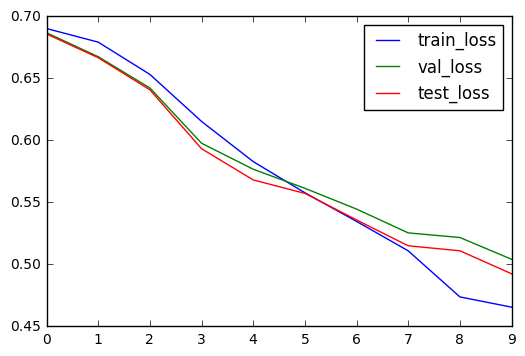

In [37]:
hist_info[['train_loss','val_loss', 'test_loss']].plot()

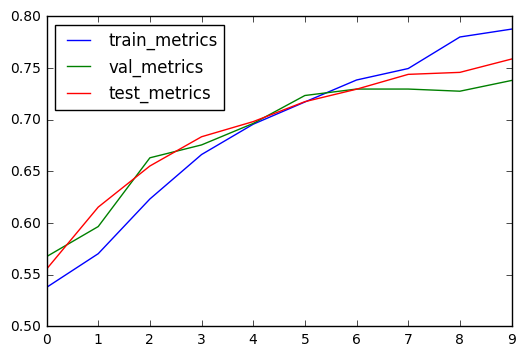

In [38]:
hist_info[['train_metrics', 'val_metrics','test_metrics',]].plot()

# CNN

In [39]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Convolution1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.layers.core import Dense, Dropout, Activation
from keras import metrics
#from keras.preprocessing import sequence

In [40]:
#nb_classes = 2

model = Sequential()
model.add(Embedding(num_words, 10, input_length= 200))
model.add(Convolution1D(activation="relu", filters=250, kernel_size=3, strides=1, padding="valid"))
model.add(MaxPooling1D(pool_size = 2))
model.add(Flatten())
model.add(Dense(250)) 
model.add(Dropout(0.2)) 
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))

#詞嵌入 採用預訓練的 向量
model.layers[0].set_weights([weights])
model.layers[0].trainable = True

#optim = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(loss='binary_crossentropy', optimizer = 'Adam' , metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 10)           200000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 198, 250)          7750      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 99, 250)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 24750)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 250)               6187750   
_________________________________________________________________
dropout_3 (Dropout)          (None, 250)               0         
_________________________________________________________________
activation_3 (Activation)    (None, 250)               0         
__________

In [41]:
%%time
history = LossHistory()
hist=model.fit(X_train, Y_train, batch_size= 32, epochs=10, validation_split=0.1, callbacks=[history])

Train on 4325 samples, validate on 481 samples
Epoch 1/10
4325/4325 [==============================] - 32s 7ms/step - loss: 0.7146 - acc: 0.5748 - val_loss: 0.6714 - val_acc: 0.5884
Epoch 2/10
4325/4325 [==============================] - 30s 7ms/step - loss: 0.5916 - acc: 0.6911 - val_loss: 0.6095 - val_acc: 0.6902
Epoch 3/10
4325/4325 [==============================] - 22s 5ms/step - loss: 0.4654 - acc: 0.7857 - val_loss: 0.5382 - val_acc: 0.7214
Epoch 4/10
4325/4325 [==============================] - 23s 5ms/step - loss: 0.3550 - acc: 0.8504 - val_loss: 0.5238 - val_acc: 0.7588
Epoch 5/10
4325/4325 [==============================] - 25s 6ms/step - loss: 0.2559 - acc: 0.9010 - val_loss: 0.5175 - val_acc: 0.7796
Epoch 6/10
4325/4325 [==============================] - 28s 6ms/step - loss: 0.1861 - acc: 0.9362 - val_loss: 0.5728 - val_acc: 0.7879
Epoch 7/10
4325/4325 [==============================] - 28s 7ms/step - loss: 0.1244 - acc: 0.9586 - val_loss: 0.6075 - val_acc: 0.8067
Epoch 8/

In [42]:
hist_info = pd.DataFrame(history.losses)

In [43]:
hist_info

,test_loss,test_metrics,train_loss,train_metrics,val_loss,val_metrics
0,0.665222,0.587767,0.714555,0.574798,0.671360,0.588358
1,0.589629,0.690227,0.591602,0.691098,0.609536,0.690229
2,0.523932,0.742081,0.465354,0.785665,0.538192,0.721414
3,0.506765,0.771727,0.355040,0.850405,0.523777,0.758836
4,0.529503,0.784158,0.255891,0.901040,0.517469,0.779626
5,0.565415,0.788162,0.186094,0.936185,0.572834,0.787942
6,0.621852,0.794508,0.124382,0.958613,0.607522,0.806653
7,0.696115,0.788891,0.080869,0.975260,0.674125,0.796258
8,0.833688,0.775992,0.056452,0.982428,0.781066,0.781705
9,0.846611,0.789723,0.037237,0.991214,0.835032,0.787942


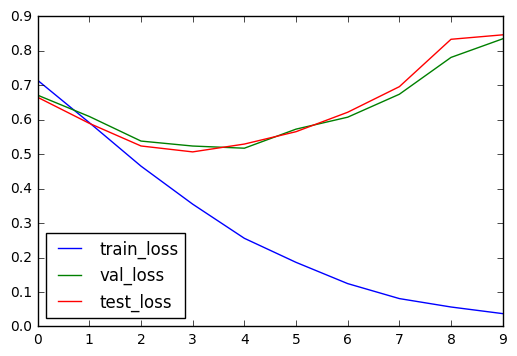

In [44]:
hist_info[['train_loss','val_loss', 'test_loss']].plot()

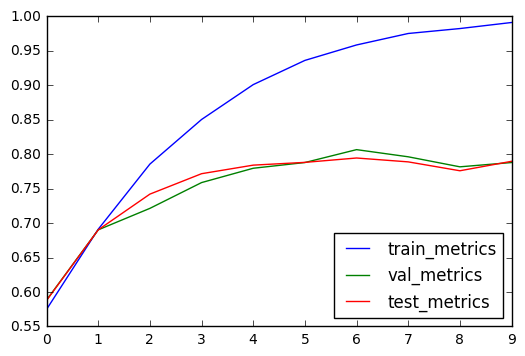

In [45]:
hist_info[['train_metrics', 'val_metrics','test_metrics',]].plot()